In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.0
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.4
sklearn 1.1.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


* 添加高空层次, 特别是逆温的判别
* 自定义损失函数

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/data/collection/"
else:
  file_dir = "H:/github/python/seafog/data/collection/"

In [3]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

In [26]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/extend/fog_dataset_extend.hdf"
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './multi_level/fog_dataset_extend_multilevels.hdf'))
fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_72h1_168h6.hdf'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')

# df_train.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_valid.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_test.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)


# x_columns = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']
df_train['delta_theta'] = df_train['theta925'] - df_train['theta1000']
df_train['delta_theta_e'] = df_train['theta_e925'] - df_train['theta_e1000']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']
df_valid['delta_theta'] = df_valid['theta925'] - df_valid['theta1000']
df_valid['delta_theta_e'] = df_valid['theta_e925'] - df_valid['theta_e1000']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']
df_test['delta_theta'] = df_test['theta925'] - df_test['theta1000']
df_test['delta_theta_e'] = df_test['theta_e925'] - df_test['theta_e1000']

x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour','delta_theta','delta_theta_e','theta_e925']

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_linear']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_linear']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_linear']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.fit_transform(valid_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]




['/test', '/train', '/valid']
(39856, 18)
(39856,)


In [34]:
def customized_mes(y_true, y_pred): # 自定义均方差
    '''
    自定义均方差
    '''

    # y_true [0,1] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [0.2,0.5,1.5,3.0]
    mse_0_1   = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     tf.square(y_pred - y_true)*0.6, 
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), tf.square(y_pred - y_true)*1.2,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     tf.square(y_pred - y_true)*2.0,
                                                                      tf.square(y_pred - y_true)*3.0)))
    # y_true [1,4/3] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [1.0,0.5,1.0,3.0]
    mse_1_43  = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     tf.square(y_pred - y_true)*1.0,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), tf.square(y_pred - y_true)*0.6,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     tf.square(y_pred - y_true)*1.5,
                                                                      tf.square(y_pred - y_true)*3.0)))
    # y_true [4/3,2] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [2.0,1.0,0.5,2.0]
    mse_43_2  = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     tf.square(y_pred - y_true)*2.2,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), tf.square(y_pred - y_true)*1.2,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     tf.square(y_pred - y_true)*0.6,
                                                                      tf.square(y_pred - y_true)*2.0)))
    # y_true [2,3] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [3.0,2.0,1.0,0.5]
    mse_2_3   = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     tf.square(y_pred - y_true)*3.0,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), tf.square(y_pred - y_true)*2.0,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     tf.square(y_pred - y_true)*1.0,
                                                                      tf.square(y_pred - y_true)*0.6)))
    sum = tf.where(tf.less_equal(y_true, tf.constant(1.0)), mse_0_1,
          tf.where(tf.less_equal(y_true, tf.constant(4.0/3.0)), mse_1_43,
          tf.where(tf.less_equal(y_true, tf.constant(2.0)), mse_43_2, mse_2_3)
          )
        )
    return tf.reduce_mean(sum)

In [35]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3,
                drop_out_layers = 2,
                drop_out_layers_size = 12,
                drop_out_rate = 0.5,):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu', 
                                kernel_regularizer=regularizers.l2(0.0001),
                                input_shape=train_x.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation = 'relu'))

    for _ in range(drop_out_layers - 1):
        model.add(keras.layers.Dense(drop_out_layers_size, activation = 'relu'))
        model.add(keras.layers.Dropout(drop_out_rate))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = customized_mes, optimizer = optimizer,metrics=["mean_squared_error",])
    return model

sklearn_model = KerasRegressor(build_fn = build_model)
# callbacks = [keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4)]
# history = sklearn_model.fit(train_x_scaled, train_y,
#                             epochs = 50,
#                             validation_data = (valid_x_scaled, valid_y),
#                             callbacks = callbacks)

C:\Users\Henry\AppData\Local\Temp\ipykernel_6628\1293799354.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = KerasRegressor(build_fn = build_model)


In [36]:
from scipy.stats import reciprocal

# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4, 5, 6, 7],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),
    "drop_out_layers":[1, 2, 3, 4, 5, 6, 7],
    "drop_out_layers_size":np.arange(1, 100),
    "drop_out_rate":[0.4, 0.45, 0.5, 0.55, 0.6]
}
callbacks = [keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4)]
from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 10,
                                      cv = 3,
                                      n_jobs = 1)
random_search_cv.fit(train_x_scaled, train_y, epochs = 500,
                     validation_data = (valid_x_scaled, valid_y),
                     callbacks = callbacks)

Epoch 1/500
831/831 [==============================] - 6s 6ms/step - loss: 3.7670 - mean_squared_error: 1.5837 - val_loss: 3.9471 - val_mean_squared_error: 1.4384
Epoch 2/500
831/831 [==============================] - 5s 6ms/step - loss: 1.9771 - mean_squared_error: 0.9575 - val_loss: 3.1945 - val_mean_squared_error: 1.2325
Epoch 3/500
831/831 [==============================] - 5s 6ms/step - loss: 1.4909 - mean_squared_error: 0.7976 - val_loss: 2.6036 - val_mean_squared_error: 1.1147
Epoch 4/500
831/831 [==============================] - 5s 6ms/step - loss: 1.2582 - mean_squared_error: 0.7175 - val_loss: 2.2618 - val_mean_squared_error: 1.0362
Epoch 5/500
831/831 [==============================] - 5s 6ms/step - loss: 1.1314 - mean_squared_error: 0.6784 - val_loss: 1.9542 - val_mean_squared_error: 0.9663
Epoch 6/500
831/831 [==============================] - 5s 5ms/step - loss: 1.0239 - mean_squared_error: 0.6478 - val_loss: 1.8034 - val_mean_squared_error: 0.9398
Epoch 7/500
831/831 [=

KeyboardInterrupt: 

In [9]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)
model = random_search_cv.best_estimator_.model
model.evaluate(test_x_scaled, test_y)

{'drop_out_layers': 2, 'drop_out_layers_size': 63, 'drop_out_rate': 0.6, 'hidden_layers': 4, 'layer_size': 92, 'learning_rate': 0.0056810867455620445}
-0.13294095794359842
142/142 [==============================] - 0s 3ms/step - loss: 0.2491 - mean_squared_error: 0.2155


[0.2491459846496582, 0.21553872525691986]

In [28]:
history = model.fit(train_x_scaled, train_y, epochs=50,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = callbacks)

Epoch 1/50
1246/1246 [==============================] - 6s 5ms/step - loss: 0.1202 - mean_squared_error: 0.1407 - val_loss: 0.1548 - val_mean_squared_error: 0.1634
Epoch 2/50
1246/1246 [==============================] - 6s 5ms/step - loss: 0.1187 - mean_squared_error: 0.1402 - val_loss: 0.1352 - val_mean_squared_error: 0.1384
Epoch 3/50
1246/1246 [==============================] - 6s 5ms/step - loss: 0.1191 - mean_squared_error: 0.1403 - val_loss: 0.1832 - val_mean_squared_error: 0.1660
Epoch 4/50
1246/1246 [==============================] - 6s 4ms/step - loss: 0.1174 - mean_squared_error: 0.1389 - val_loss: 0.1385 - val_mean_squared_error: 0.1384
Epoch 5/50
1246/1246 [==============================] - 5s 4ms/step - loss: 0.1231 - mean_squared_error: 0.1425 - val_loss: 0.1757 - val_mean_squared_error: 0.1767
Epoch 6/50
1246/1246 [==============================] - 6s 5ms/step - loss: 0.1186 - mean_squared_error: 0.1391 - val_loss: 0.1420 - val_mean_squared_error: 0.1429
Epoch 7/50
1246/

In [21]:

# model_path = os.path.join(file_dir, './fulltime/model_0.818')
# tf.keras.models.save_model(
#     model, model_path, overwrite=True, include_optimizer=True, save_format=None,
#     signatures=None, options=None, save_traces=True
# )
model_path = os.path.join(file_dir, './fulltime/model_loss_customized_hp_')
tf.keras.models.save_model(
    model, model_path, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

INFO:tensorflow:Assets written to: F:/github/pythonScript/seafog/data/collection/./fulltime/model_0.818/model.tf\assets


In [ ]:
model.summary()

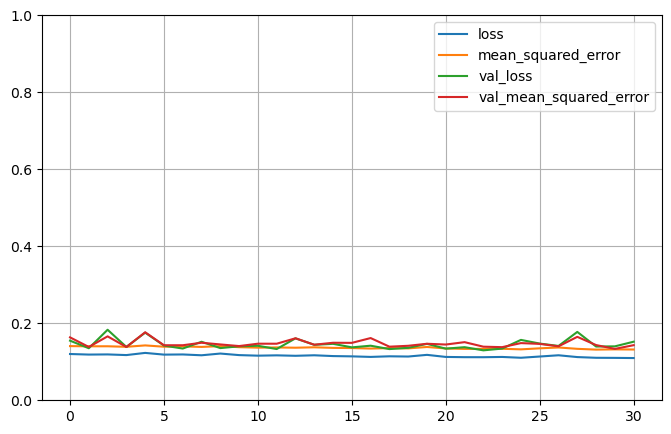

In [29]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [31]:
model.evaluate(test_x_scaled, test_y, verbose=0)

[0.2490251362323761, 0.19685477018356323]

* 默认方法MSE 在0.36左右，关键因素是温度和日期
* 添加t-td 等函数后，MSE 在0.3
* hp 搜索后MSE达到了0.245

In [32]:
predictions = model(test_x_scaled).numpy()
predictions

array([[0.5423771 ],
       [0.44340718],
       [0.9048815 ],
       ...,
       [2.962214  ],
       [2.0175178 ],
       [2.2394521 ]], dtype=float32)

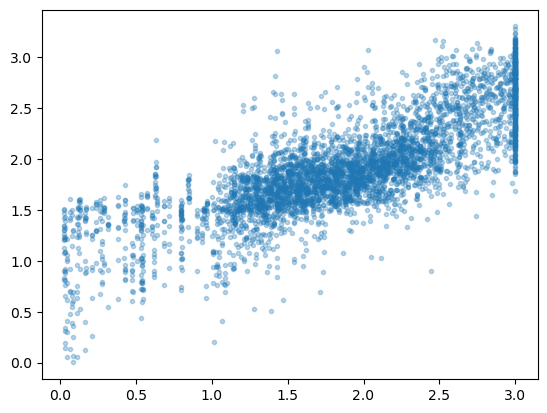

相关系数0.807725234720979, p值为0.00000


In [33]:
plt.plot(test_y, predictions,'.', alpha=0.3)
plt.show()
r,p = pearsonr(predictions[:,0],test_y)
print(f'相关系数{r}, p值为{p:.5f}')

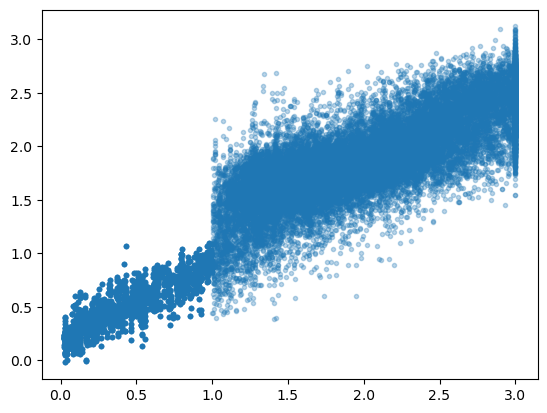

In [22]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.', alpha=0.3)
plt.show()

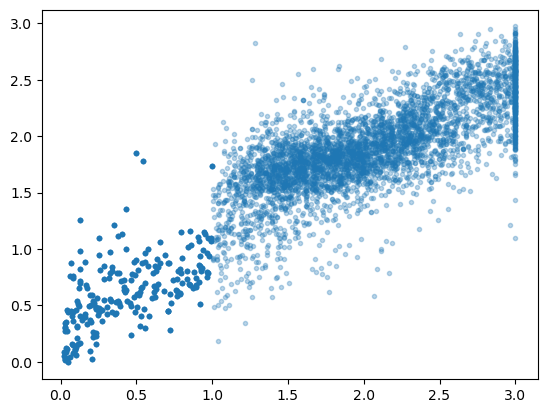

In [23]:
plt.plot(valid_y,model(valid_x_scaled).numpy(),'.', alpha=0.3)
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].values,train_y,'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].values,df_train['visi'],'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis)))

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 